In [1]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import time
import numpy as np

from SES_setup import *
from utils import *
from style import *

SES_setup loaded globally


In [2]:
def rate_to_state(init_rho, final_rho, L):
    rho_dot = qt.vector_to_operator(L*qt.operator_to_vector(init_rho))
    return (rho_dot*final_rho).tr()

def rate_to_manifold(init_rho, L, ops, manifold='OO'):
    if manifold == 'ground':
        manifold = 'OO'
    rho_dot = qt.vector_to_operator(L*qt.operator_to_vector(init_rho))
    return (rho_dot*ops[manifold]).tr()




# Displacements
Defining everything via the IBM hamiltonian and taking into account the normalisation of the displacement operator gives the right answers for this known test case. However, with RC mapping parameters and spectral densities taken from the [J. Chem. Phys paper](https://aip.scitation.org/doi/10.1063/1.4940218) and the Liouvillians defined in my code/notes, which agree with Redfield without any hacky prefactors, it appears like $\alpha_{ph}$ is missing a factor of 4 (or $\kappa$ is missing a factor of 2). This gives a factor of 2 error in the displacment of the modes. I think my approach now will be to include a factor of $1/2$ in the definition of the displacement, so that the re. I'll fully resolve this issue later on.

In [3]:
80/ev_to_inv_cm

0.00991878990763127

In [4]:
def plot_decay_rates(data_dict, couplings):
    for w0, dat in data_dict.items(): # for each w0, unpack data which is dictionary with keys [btd, dtg, btg]
        # for each set of rates, plot a new figure
        displacements = [c/float(w0) for c in couplings] 
        for rate_type, rate_data in dat.items(): # for each set of rates, plot each
            plt.figure()
            plt.title(rate_type +' '+ w0)
            for label, data_set in rate_data.items():
                if (rate_type != 'btd') and (label == 'wc'):
                    data_set = np.array(data_set)
                if (label != 'wc'):
                    plt.plot(displacements, data_set, label=label)
            plt.legend()

In [5]:
def sort_eigs(evals, evecs):
    idx = evals.argsort()
    return evals[idx], evecs[idx]

def dark_bright_check(states, ops):
    # ensures the states have the correct symmetry properties
    dark_states = states['dark']
    bright_states = states['bright']
    ground_states = states['ground']
    i = 0
    for g in ground_states:
        assert abs((g*g.dag()*ops["OO"]).tr()-1) <1e-10
        for d in dark_states:
            assert abs((d.dag()*g).tr()) <1e-10
    for d in dark_states:
        #print((d.dag()*d).tr())
        assert abs((d.dag()*d).tr()-1) <1e-10
        for b in bright_states:
            #print ((d.dag()*b))
            assert abs((b.dag()*b).tr()-1) <1e-10
            assert abs((d.dag()*b).tr()) <1e-10
            assert abs((d.dag()*d).tr()-1) <1e-10
            i += 1

            

def separate_states(H, PARAMS, trunc=0.8):
    # truncation removes the really dodgy states for which the parity is unclear 
    # (this might not be numerical error, but it probs is)
    ops = make_expectation_operators(PARAMS)
    energies, states = H.eigenstates()
    energies, states = sort_eigs(energies, states)
    energies, states = energies[0:int(len(states)*trunc)], states[0:int(len(states)*trunc)]
    parities = [(state*state.dag()*ops['sigma_x']).tr() for state in states]
    phonon_occ_dict = {'dark': [], 'bright': [], 'ground': []}
    states_dict = {'dark': [], 'bright': [], 'ground': []}
    energies_dict = {'dark': [], 'bright': [], 'ground': []} # for checking
    for i, parity in enumerate(parities):
        occ_1 = (states[i].dag()*ops['RC1_number']*states[i]).tr().real
        occ_2 = (states[i].dag()*ops['RC2_number']*states[i]).tr().real
        if abs(parity)<1e-10:
            states_dict['ground'].append(states[i])
            energies_dict['ground'].append(energies[i])
            phonon_occ_dict['ground'].append((occ_1, occ_2))
        elif parity>1e-10:
            states_dict['bright'].append(states[i])
            energies_dict['bright'].append(energies[i])
            phonon_occ_dict['bright'].append((occ_1, occ_2))
        elif parity<-1e-10:
            states_dict['dark'].append(states[i])
            energies_dict['dark'].append(energies[i])
            phonon_occ_dict['dark'].append((occ_1, occ_2))
        else:
            raise ValueError("Parity is {} ".format(parity))
    if len(states_dict['ground'])  == len(states):
        print("This will not work for V=0. Ground contains all states.")
    #print(len(states_dict['dark']), len(states_dict['bright']), len(states_dict['ground']))
    #assert (len(states_dict['dark']) == len(states_dict['bright']))
    dark_bright_check(states_dict, ops)
    return energies_dict, states_dict, phonon_occ_dict

# Low Temperature characterisation

In the first instance, I need to understand what happens at low phonon and EMF temperature. Just choose some sensible parameters (say from monomer paper or Dominic's dimer paper) and calculate. $\omega_0 = 30meV, 60meV, 120meV$
- $|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=0$
- $|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=0$ Does increasing phonon coupling actually increase population of dark state? Is this because $\sigma_x$ gains displacement operators?
- $|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=0$ 

Then I'll be in a position to understand EMF thermal occupation. Steadystate population is likely to be $\propto\Gamma_{g,+}/\Gamma_{-,0}$, unless dominated by phonon reorganisation.
- $|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=6000$

Can I then characterise population by $\Gamma_{g,+}/\Gamma_{-,0}$? In the first instance just from zero states to manifolds.

In [6]:
def displace(offset, a):
    return (offset*(a.dag())/sqrt(2) - offset.conjugate()*a/sqrt(2)).expm()

def undisplaced_initial(init_sys, PARAMS):
    n1 = Occupation(PARAMS['w0_1'], PARAMS['T_1'])
    n2 = Occupation(PARAMS['w0_2'], PARAMS['T_2'])
    return tensor(init_sys, qt.enr_thermal_dm([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'], 
                                              [n1, n2]))
def position_ops(PARAMS):
    atemp = enr_destroy([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
    return [tensor(I_sys, (a + a.dag())/sqrt(2)) for a, omega in zip(atemp, [PARAMS['w0_1'], PARAMS['w0_2']])]


def offsets(init_sys, PARAMS):
    energies, states = exciton_states(PARAMS)
    normal_disp_1 = sqrt(pi*PARAMS['alpha_1']/(2*PARAMS['w0_1']))
    normal_disp_2 = sqrt(pi*PARAMS['alpha_2']/(2*PARAMS['w0_2']))
    eta = sqrt(PARAMS['bias']+4*PARAMS['V'])
    coeff_p = (eta + PARAMS['bias'])/(2*eta)
    coeff_m = (eta - PARAMS['bias'])/(2*eta)
    if init_sys == 'dark':
        return states[0], normal_disp_1*coeff_m, normal_disp_2*coeff_p
    elif init_sys == 'bright':
        return states[1], normal_disp_1*coeff_p, normal_disp_2*coeff_m
    elif init_sys == 'ground':
        return OO, 0, 0
    else:
        raise KeyError("Please choose dark, bright or ground")

def displaced_initial(PARAMS, init_sys='dark', silent=False, return_error=False):
    init_state, offset_1, offset_2 = offsets(init_sys, PARAMS)
    atemp = enr_destroy([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
    x = position_ops(PARAMS)
    r0 = undisplaced_initial(init_state*init_state.dag(), PARAMS)
    disp = copy.deepcopy(r0)
    for offset, a_ in zip([offset_1, offset_2], atemp):
        d = tensor(I_sys, displace(offset, a_))
        disp =  d * disp * d.dag()
    try:
        error = 100*(abs((disp*x[0]).tr()- offset_1)/offset_1 + abs((disp*x[1]).tr()- offset_2)/offset_2)
        if error>0.5:
            print ("Error in displacement: {:0.8f}%. Predicted {:0.4f} , actual {:0.4f}".format(error, offset_1, (disp*x[0]).tr()))
            print ("Ratio of kBT to Omega: {:0.4f}".format(0.695*PARAMS['T_1']/PARAMS['w0_1']))
            if ((PARAMS['T_1'] != PARAMS['T_2']) or (PARAMS['w0_1'] != PARAMS['w0_2'])):
               print("Ratio of kBT to Omega (2): {:0.4f}".format(0.695*PARAMS['T_2']/PARAMS['w0_2']))
        if return_error:   
            return disp, error
        else:
            return disp
    except:
        return disp


In [7]:
def plot_manifold_rates(data_dict, title = 'dtg', show_total_decay=False):
    couplings =data_dict['couplings']
    for omega_0, data in data_dict.items():
        if omega_0 == 'couplings':
            couplings = data
        else:
            plt.figure()
            plt.title(title+ ' ' + omega_0)
            i=0
            for rate_name, rate_data in data.items():
                if(  (abs(sum(rate_data['nonadd'])) <1e-9)):
                    pass # we don't really want the total decay rate in there, or any that are zero
                else:
                    c = colourWheel[i]
                    plt.plot(couplings, rate_data['nonadd'], linestyle='solid', label=rate_name, c=c) 
                    plt.plot(couplings, rate_data['add'], linestyle='dashed', c=c)
                    i+=1
            plt.legend()

In [12]:
def thermal_to_states(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., T_EM=0.,
                         N=5, start_manifold='dark', end_manifold='OO'):
    # Characterise low T_ph behaviour of decay
    eta = sqrt(bias**2 + 4*V**2)
    Omegas = np.array([ 30e-3, 60e-3, 120e-3])*ev_to_inv_cm
    couplings = np.linspace(0.1,50,20)
    data_names = ["{}".format(int(i)) for i in Omegas]
    in_in_dict = {'nonadd':[], 'add': []}
    state_indexes = [0,0,1,2,3,4,5]
    data_dict = {}
    #                   'btd': copy.deepcopy(in_in_dict)} for key in data_names}
    i = 0
    for w_0 in Omegas:
        inner_data_dict = {'st-manifold': copy.deepcopy(in_in_dict),
                'st-f0': copy.deepcopy(in_in_dict), 
               'st-f1': copy.deepcopy(in_in_dict),
               'st-f2': copy.deepcopy(in_in_dict),
               'st-f3': copy.deepcopy(in_in_dict),
                'st-f4': copy.deepcopy(in_in_dict),
                'st-f5': copy.deepcopy(in_in_dict)}
        for alpha in couplings:
            #N=3
            PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                              silent=True, exc_diff=N)
            #PARAMS = get_converged_N(PARAMS, err_threshold=0.5, max_N=12, exc_diff_N=True) # Turn ENR off
            H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
            energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
            ops = make_expectation_operators(PARAMS)
            ri_nonadd = steadystate(H[1], [L['nonadd']])
            ri_add = steadystate(H[1], [L['add']])
            #displaced_initial(PARAMS, init_sys=start_manifold, silent=False, return_error=False)
            LVN  = -1j*(qt.spre(H[1]) - qt.spost(H[1]))
            for idx, state_label in zip(state_indexes, inner_data_dict.keys()):
                if state_label == 'st-manifold': # Can check decay to whole target manifold
                    inner_data_dict[state_label]['nonadd'].append(rate_to_manifold(ri_nonadd, LVN+L['nonadd'], 
                                                                             ops, manifold=end_manifold))
                    inner_data_dict[state_label]['add'].append(rate_to_manifold(ri_add, LVN+L['add'], 
                                                                             ops, manifold=end_manifold))
                else:
                    sf = states_dict[end_manifold][idx]
                    rf = sf*sf.dag()
                    inner_data_dict[state_label]['nonadd'].append(rate_to_state(ri_nonadd, rf, LVN+L['nonadd']))
                    inner_data_dict[state_label]['add'].append(rate_to_state(ri_add, rf, LVN+L['add']))
            i+=1
            if i%10 == 0:
                print (i)
        data_dict.update({str(int(w_0)) : inner_data_dict})
    print("Calculation complete")
    data_dict.update({'couplings' : couplings})
    return data_dict

In [13]:
w_2 = 1.4 * ev_to_inv_cm
bias = 0 # 10e-3 * ev_to_inv_cm
V = 10e-3 * ev_to_inv_cm
alpha = 1e-3 * ev_to_inv_cm
T_EM = 0.
T_ph = 150
alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
#w0 = 1.2*eta# 18e-3*ev_to_inv_cm
Gamma = 80. #2*w0
print (eta, V/eta)

161.31 0.5


In [14]:
N = 4

In [15]:
dark_ground_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='dark', end_manifold='ground')
ground_dark_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='ground', end_manifold='dark')

10
20
30
40
50
60
Calculation complete
10
20
30
40
50
60
Calculation complete


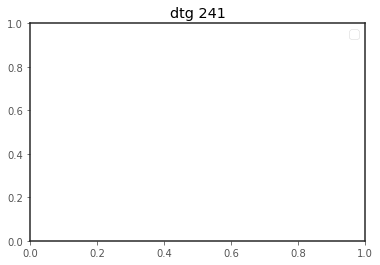

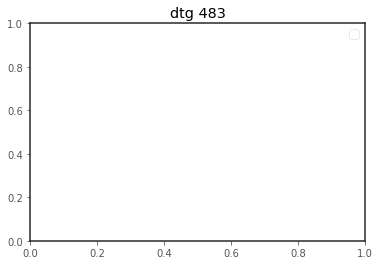

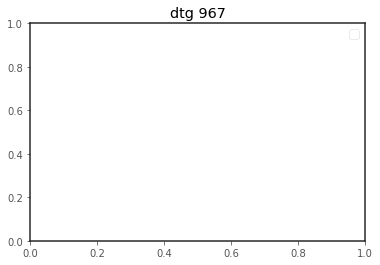

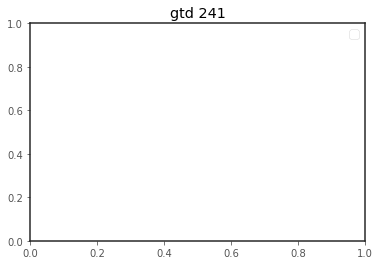

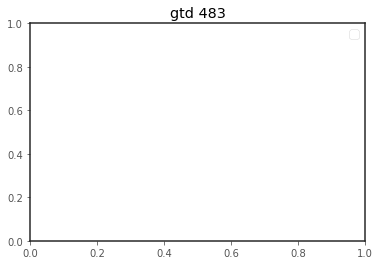

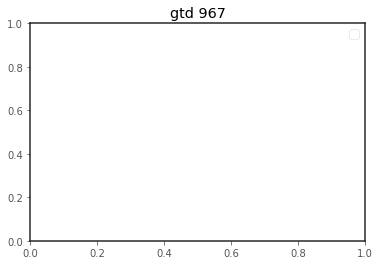

In [16]:
plot_manifold_rates(dark_ground_high_T, title='dtg')
plot_manifold_rates(ground_dark_high_T, title='gtd')

In [17]:
bright_ground_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='bright', end_manifold='ground')
ground_bright_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='ground', end_manifold='bright')

10
20
30
40
50
60
Calculation complete
10
20
30
40
50
60
Calculation complete


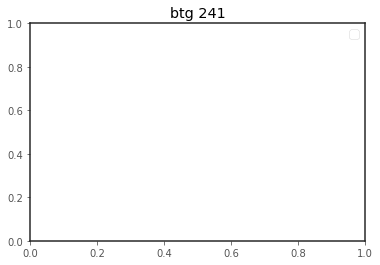

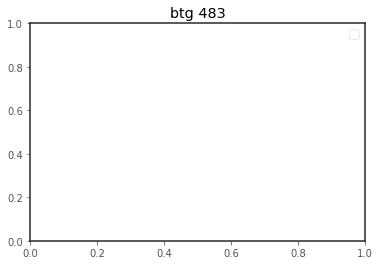

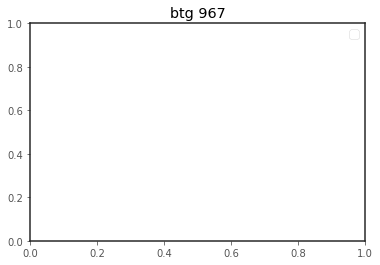

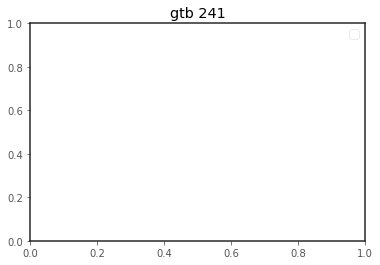

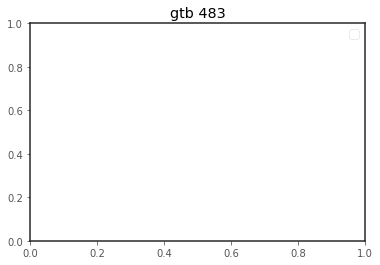

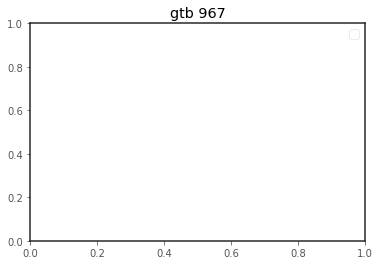

In [18]:
plot_manifold_rates(bright_ground_high_T, title='btg')
plot_manifold_rates(ground_bright_high_T, title='gtb')

In [19]:
bright_dark_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='bright', end_manifold='dark')
dark_bright_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='dark', end_manifold='bright')


10
20
30
40
50
60
Calculation complete
10
20
30
40
50
60
Calculation complete


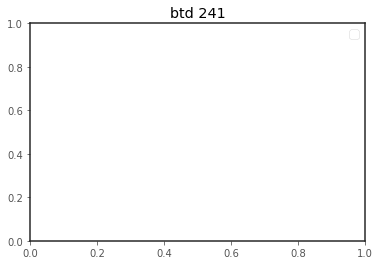

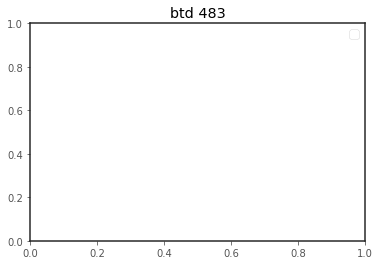

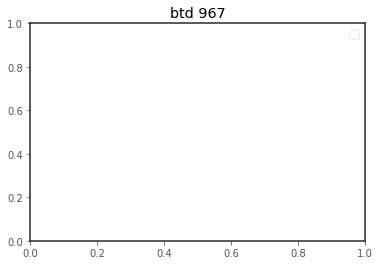

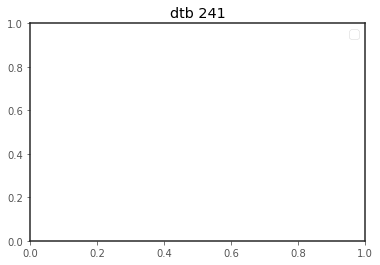

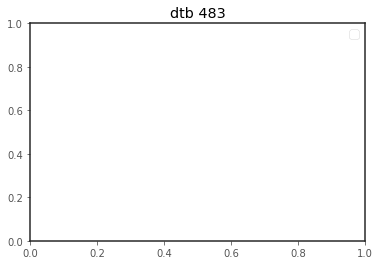

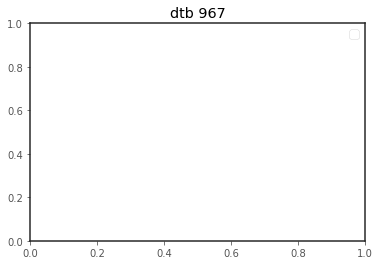

In [20]:
plot_manifold_rates(bright_dark_high_T, title='btd')
plot_manifold_rates(dark_bright_high_T, title='dtb')

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


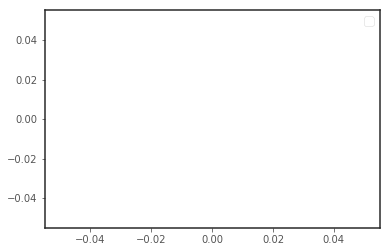

In [21]:

def full_population_ratio(gd, gb, dg, db, bg, bd):
    A = dg + db*(1- (bd/(bd+bg)))
    return gd/A + (bd*gb)/(A*(bd+bg))

for w0_mag in ['241', '483', '967']:
    bg_rate = np.array(bright_ground_high_T[w0_mag]['st-manifold']['nonadd'])
    gb_rate = np.array(ground_bright_high_T[w0_mag]['st-manifold']['nonadd'])
    gd_rate = np.array(ground_dark_high_T[w0_mag]['st-manifold']['nonadd'])
    dg_rate = np.array(dark_ground_high_T[w0_mag]['st-manifold']['nonadd'])
    
    db_rate = np.array(dark_bright_high_T[w0_mag]['st-f0']['nonadd'])
    bd_rate = np.array(bright_dark_high_T[w0_mag]['st-f0']['nonadd'])
    #print ((gb_rate+gd_rate)/dg_rate)
    #plt.plot((gb_rate+gd_rate)/dg_rate, label=w0_mag)
    plt.plot(full_population_ratio(gd_rate, gb_rate, dg_rate, db_rate, bg_rate, bd_rate), )
    plt.legend()

$|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=0$

$|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=0$

- These rates suggest that the zero phonon transition is the largest between bright and dark.
- The $|\psi_+^{0}\rangle \to |-\rangle$ rate is predicted to be zero, which doesn't make sense. I can't work out why this would be the case, unless it's do with with product state thing again.
- Strangely, increasing $\omega_0$ decreases the bright-to-dark rate. This is exactly the same in both non-additive and additive cases. 

When $\omega_0$ increases, the overlap between ground and exciton states increases due to smaller displacement. This might cause the excitonic coupling to be smaller since these terms gain

$|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=0$ 

# Thermal Occupation of EMF

- $|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=6000$

In [ ]:
w_2 = 1.4 * ev_to_inv_cm
bias = 10e-3 * ev_to_inv_cm
V = 10e-3 * ev_to_inv_cm
alpha = 1e-3 * ev_to_inv_cm
T_EM = 0.
T_ph = 150
alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
#w0 = 1.2*eta# 18e-3*ev_to_inv_cm
Gamma = 80. #2*w0
print (eta, V/eta)

In [ ]:
dark_ground_ = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=7, T_EM=6000,
                                                      start_manifold='dark', end_manifold='ground')
ground_dark_ = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=7, T_EM=6000,
                                                      start_manifold='ground', end_manifold='dark')

In [77]:
ground_dark_

{'241': {'st-manifold': {'nonadd': [0.0036370799304901347,
    0.0036361225941570793,
    0.0036351654808529474,
    0.0036342085913821176,
    0.0036332519247738028,
    0.0036322954818549034,
    0.0036313392619572345,
    0.0036303832654682898,
    0.0036294274921595503,
    0.0036284719414502523,
    0.003627516614643467,
    0.003626561510421563,
    0.003625606629621769,
    0.003624651971431415,
    0.003623697537292615,
    0.0036227433253801507,
    0.0036217893358830747,
    0.0036208355693663563,
    0.003619882025790894,
    0.0036189287048214677,
    0.0036179756065891342,
    0.0036170227307864185,
    0.003616070077579817,
    0.003615117647136695,
    0.003614165440034941,
    0.0036132134549289163,
    0.003612261691885424,
    0.0036113101519156497,
    0.0036103588341880647,
    0.0036094077380795938,
    0.0036084568650251955,
    0.003607506213154435,
    0.003606555784341981,
    0.0036056055777374924,
    0.003604655592581076,
    0.003603705830277211,
    0.0036

In [ ]:
plot_manifold_rates(dark_ground_, title='dtg')
plot_manifold_rates(ground_dark_, title='gtd')

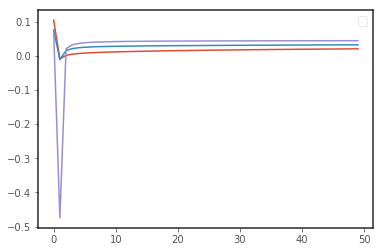

In [99]:
w0_mag = '483'
def full_population_ratio(gd, gb, dg, db, bg, bd):
    A = dg + db*(1- (bd/(bd+bg)))
    return gd/A + (bd*gb)/(A*(bd+bg))

for w0_mag in ['241', '483', '967']:
    bg_rate = np.array(bright_ground[w0_mag]['st-manifold']['nonadd'])
    gb_rate = np.array(ground_bright[w0_mag]['st-manifold']['nonadd'])
    gd_rate = np.array(ground_dark_[w0_mag]['st-manifold']['nonadd'])
    dg_rate = np.array(dark_ground_[w0_mag]['st-manifold']['nonadd'])
    
    db_rate = np.array(dark_bright_high[w0_mag]['st-f0']['nonadd'])
    bd_rate = np.array(bright_dark_high[w0_mag]['st-f0']['nonadd'])
    #print ((gb_rate+gd_rate)/dg_rate)
    #plt.plot((gb_rate+gd_rate)/dg_rate, label=w0_mag)
    plt.plot(full_population_ratio(gd_rate, gb_rate, dg_rate, db_rate, bg_rate, bd_rate), )
    plt.legend()

In [74]:
bright_ground = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=7, T_EM=6000,
                                                      start_manifold='bright', end_manifold='ground')
ground_bright = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=7, T_EM=6000,
                                                      start_manifold='ground', end_manifold='bright')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Calculation complete
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Calculation complete


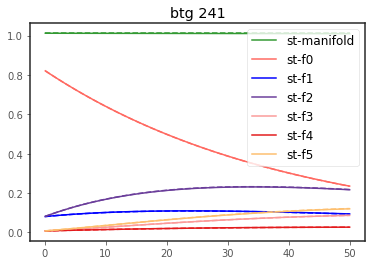

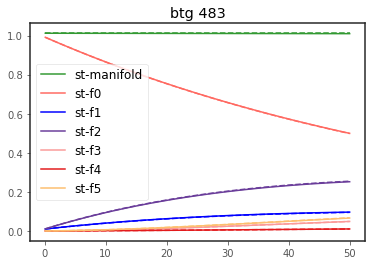

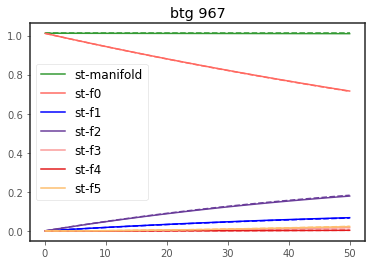

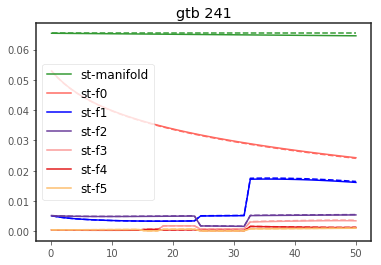

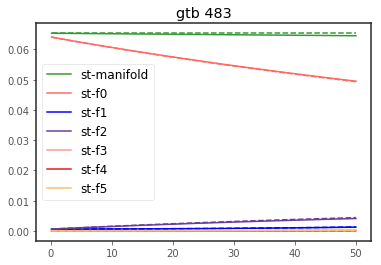

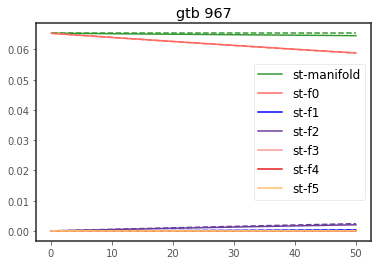

In [75]:
plot_manifold_rates(bright_ground, title='btg')
plot_manifold_rates(ground_bright, title='gtb')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Calculation complete
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Calculation complete


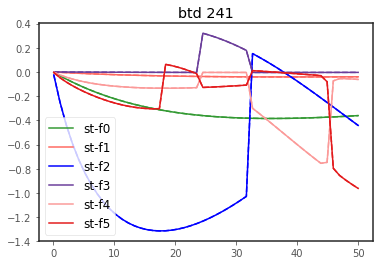

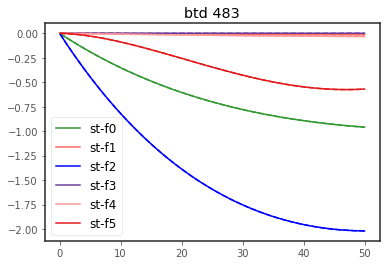

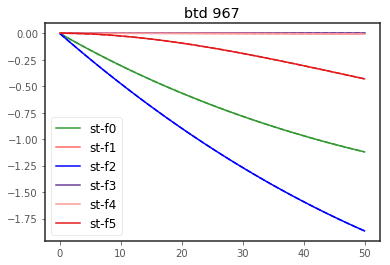

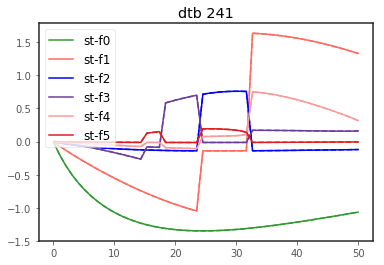

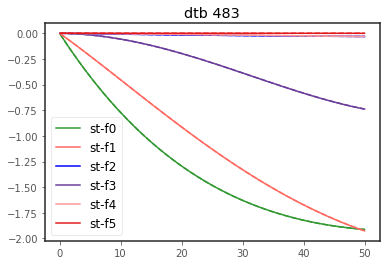

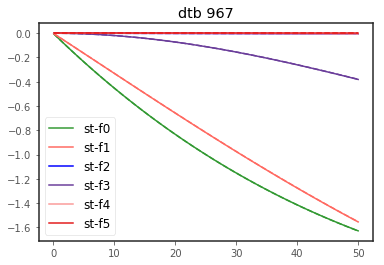

In [76]:
bright_dark_high = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=7, T_EM=6000,
                                                      start_manifold='bright', end_manifold='dark')
dark_bright_high = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=7, T_EM=6000,
                                                      start_manifold='dark', end_manifold='bright')
plot_manifold_rates(bright_dark_high, title='btd')
plot_manifold_rates(dark_bright_high, title='dtb')

$\Gamma_{+,g}$ is not a function of optical field temperature, but $\Gamma_{g,+}$ is.

# $\Gamma_{g,+}/\Gamma_{-,0}$

In [44]:
def pressure_rate(bright_up, bright_down, 
                  dark_up, dark_down, add_type='nonadd'):
    num = np.array(bright_up[add_type])+np.array(dark_up[add_type])
    print (np.array(dark_down[add_type]))
    return num/(np.array(dark_down[add_type]))

def plot_population_pressure(ground_bright, bright_ground, ground_dark, dark_ground):
    # Should be for high EMF temperature
    couplings =ground_bright['couplings']
    plt.figure()
    plt.title(r"$\Gamma_{g,+}/\Gamma_{-,g}$")
    for i, omega_0 in enumerate(ground_bright.keys()):
        if omega_0 == 'couplings':
            pass
        else:
            (bright_up, bright_down, dark_up, dark_down) = (ground_bright[omega_0]['s0-f0'], 
                                                                bright_ground[omega_0]['s0-f0'], 
                                                                ground_dark[omega_0]['s0-f0'], 
                                                                dark_ground[omega_0]['s0-f0'])
            
            c = colourWheel[i]
            plt.plot(couplings, pressure_rate(bright_up, bright_down, 
                                              dark_up, dark_down, add_type='nonadd'), 
                     linestyle='solid', label=omega_0, c=c)
            plt.plot(couplings, pressure_rate(bright_up, bright_down, 
                                              dark_up, dark_down, add_type='add'), 
                     linestyle='dashed', c=c)
    plt.legend()

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


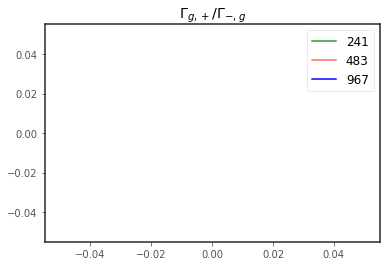

In [45]:
plot_population_pressure(ground_bright_high_T, bright_ground_high_T, ground_dark_high_T, dark_ground_high_T) 

This metric that I have made: the larger it is, the more highly populated the system should be at steadystate